In [4]:
import pandas as pd
import sqlite3
import os

# --- MENTÖR NOTU: Dosya Yolunu Kontrol Etme ---
# Eğer dosya ismin veya klasörün farklıysa burayı güncellemen gerekir.
file_path = 'home-credit-default-risk/application_train.csv'

# Dosya gerçekten orada mı diye Python'a kontrol ettirelim (Hata almamak için)
if os.path.exists(file_path):
    print(f"Dosya bulundu: {file_path} ✅")
else:
    print(f"HATA: Dosya '{file_path}' adresinde bulunamadı! ❌ Klasör ismini kontrol et.")

# 1. CSV dosyasını oku (Doğru yoldan)
df = pd.read_csv(file_path)

# 2. SQLite veritabanına bağlan (Yoksa oluşturur)
conn = sqlite3.connect('home_credit_db.sqlite')

# 3. Veriyi SQL tablosuna yaz
# if_exists='replace': Tablo varsa silip yenisini yazar (Hata almanı engeller)
df.to_sql('train_data', conn, if_exists='replace', index=False)

print("Veri başarıyla SQL ortamına yüklendi ve 'train_data' tablosu oluştu! 🚀")

Dosya bulundu: home-credit-default-risk/application_train.csv ✅
Veri başarıyla SQL ortamına yüklendi ve 'train_data' tablosu oluştu! 🚀


In [5]:
%load_ext sql
%sql sqlite:///home_credit_db.sqlite

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [6]:
%%sql
SELECT
    COUNT(*) AS toplam_basvuru_sayisi,
    SUM(TARGET) AS temerrude_dusen_sayisi,
    ROUND(AVG(TARGET) * 100, 2) AS temerrut_orani_yuzde
FROM
    train_data;

Running query in 'sqlite:///home_credit_db.sqlite'

toplam_basvuru_sayisi,temerrude_dusen_sayisi,temerrut_orani_yuzde
307511,24825,8.07


In [7]:
%%sql
SELECT 
    NAME_INCOME_TYPE AS gelir_tipi,
    COUNT(*) AS kisi_sayisi,
    ROUND(AVG(TARGET) * 100, 2) AS temerrut_orani
FROM 
    train_data
GROUP BY 
    NAME_INCOME_TYPE
ORDER BY 
    temerrut_orani DESC;

Running query in 'sqlite:///home_credit_db.sqlite'

gelir_tipi,kisi_sayisi,temerrut_orani
Maternity leave,5,40.0
Unemployed,22,36.36
Working,158774,9.59
Commercial associate,71617,7.48
State servant,21703,5.75
Pensioner,55362,5.39
Student,18,0.0
Businessman,10,0.0


In [9]:
%%sql
SELECT 
    NAME_INCOME_TYPE AS gelir_tipi,
    NAME_EDUCATION_TYPE AS egitim_seviyesi,
    COUNT(*) AS kisi_sayisi,
    ROUND(AVG(TARGET) * 100, 2) AS temerrut_orani
FROM 
    train_data
GROUP BY 
    NAME_INCOME_TYPE, NAME_EDUCATION_TYPE
HAVING 
    COUNT(*) > 500 -- Sadece 500 kişiden fazla olan anlamlı gruplara bakalım
ORDER BY 
    temerrut_orani ASC;

Running query in 'sqlite:///home_credit_db.sqlite'

gelir_tipi,egitim_seviyesi,kisi_sayisi,temerrut_orani
State servant,Higher education,8863,3.88
Pensioner,Higher education,8188,4.15
Pensioner,Incomplete higher,518,4.44
Commercial associate,Higher education,24025,5.17
Pensioner,Secondary / secondary special,45101,5.58
Working,Higher education,33762,6.17
Pensioner,Lower secondary,1529,6.67
State servant,Incomplete higher,770,6.75
State servant,Secondary / secondary special,11945,7.07
Commercial associate,Incomplete higher,3400,8.21


In [10]:
%%sql
SELECT 
    CASE 
        WHEN ABS(DAYS_BIRTH) / 365 < 30 THEN '20-30 Yas Arasi'
        WHEN ABS(DAYS_BIRTH) / 365 BETWEEN 30 AND 40 THEN '30-40 Yas Arasi'
        WHEN ABS(DAYS_BIRTH) / 365 BETWEEN 40 AND 50 THEN '40-50 Yas Arasi'
        WHEN ABS(DAYS_BIRTH) / 365 BETWEEN 50 AND 60 THEN '50-60 Yas Arasi'
        ELSE '60+ Yas'
    END AS yas_grubu,
    COUNT(*) AS kisi_sayisi,
    ROUND(AVG(TARGET) * 100, 2) AS temerrut_orani
FROM 
    train_data
GROUP BY 
    yas_grubu
ORDER BY 
    yas_grubu;

Running query in 'sqlite:///home_credit_db.sqlite'

yas_grubu,kisi_sayisi,temerrut_orani
20-30 Yas Arasi,45000,11.46
30-40 Yas Arasi,90923,9.44
40-50 Yas Arasi,74401,7.55
50-60 Yas Arasi,67819,5.93
60+ Yas,29368,4.92


/var/folders/t5/7btk0g796859p05f6lyczhn80000gn/T/ipykernel_86431/3681657111.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='yas_grubu', y='temerrut_orani', data=df_age_risk, palette='viridis')


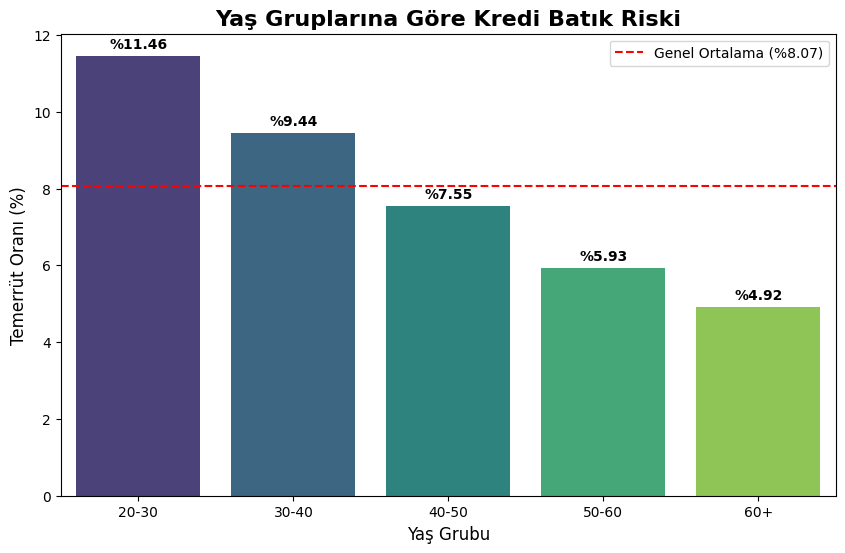

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. SQL Sorgusunu bir değişkene (DataFrame) atayalım
# Not: %sql komutunun sonucunu bir değişkene atamak için '<<' operatörü veya tek satırlık %sql kullanılır.
# Ancak en temiz yöntem, sorguyu bir stringe yazıp pandas ile çekmektir.

query = """
SELECT 
    CASE 
        WHEN ABS(DAYS_BIRTH) / 365 < 30 THEN '20-30'
        WHEN ABS(DAYS_BIRTH) / 365 BETWEEN 30 AND 40 THEN '30-40'
        WHEN ABS(DAYS_BIRTH) / 365 BETWEEN 40 AND 50 THEN '40-50'
        WHEN ABS(DAYS_BIRTH) / 365 BETWEEN 50 AND 60 THEN '50-60'
        ELSE '60+'
    END AS yas_grubu,
    ROUND(AVG(TARGET) * 100, 2) AS temerrut_orani
FROM 
    train_data
GROUP BY 
    yas_grubu
ORDER BY 
    yas_grubu;
"""

# Veriyi SQL'den çek
df_age_risk = pd.read_sql(query, conn)

# 2. Profesyonel Grafik Çizimi
plt.figure(figsize=(10, 6)) # Çerçevenin boyutu

# Seaborn ile Barplot (Çubuk Grafik)
sns.barplot(x='yas_grubu', y='temerrut_orani', data=df_age_risk, palette='viridis')

# Grafiği Süsleyelim
plt.title('Yaş Gruplarına Göre Kredi Batık Riski', fontsize=16, fontweight='bold')
plt.xlabel('Yaş Grubu', fontsize=12)
plt.ylabel('Temerrüt Oranı (%)', fontsize=12)
plt.axhline(y=8.07, color='r', linestyle='--', label='Genel Ortalama (%8.07)') # Kırmızı çizgi ile ortalamayı göster
plt.legend() # Etiketi göster

# Değerleri çubukların üzerine yazalım
for index, row in df_age_risk.iterrows():
    plt.text(index, row.temerrut_orani + 0.2, f"%{row.temerrut_orani}", color='black', ha="center", fontweight='bold')

plt.show()